Navid Azadegan

 Data Preparation with some modification and formatting

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
def store_relational_JH_data():
    ''' Transformes the COVID data in a relational data set
    '''
data_path1='file:///C:/Users/navid/covid/data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
pd_raw=pd.read_csv(data_path1)
pdb=pd_raw.rename(columns={'Country/Region':'country',
                      'Province/State':'state'})
pdb['state']=pdb['state'].fillna('no')
pdb=pdb.drop(['Lat','Long'],axis=1)
prm=pdb.set_index(['state','country']) \
                                .T                              \
                                .stack(level=[0,1])             \
                                .reset_index()                  \
                                .rename(columns={'level_0':'date',
                                                   0:'confirmed'},
                                                  )
prm['date']=prm.date.astype('datetime64[ns]')
prm.to_csv('C:/Users/navid/covid/data/processed/COVID_relational_confirmed.csv',sep=';',index=False)

if __name__ == '__main__':

    store_relational_JH_data()

SIR Data Preparation with some modification and formatting-----SIR-------------SIR-------------SIR-------------SIR--------

In [2]:
time_idx=pd_raw.columns[4:]
df_plot = pd.DataFrame({
    'date':time_idx})
data_path2='file:///C:/Users/navid/covid/data/raw/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
pd_raw2=pd.read_csv(data_path2) #Country Population
#country_list=pd_raw2.Country_Region.unique()
#pd_raw2[pd_raw2.Country_Region=='Germany'].Population
df2 = pd.DataFrame(pd_raw2)
df2_1=df2.rename(columns={'Country_Region':'country'})
df2_2=df2_1.drop(['UID', 'iso2','iso3','code3','FIPS','Admin2','Lat','Long_','Combined_Key'], axis=1)
df2_3=df2_2[df2_2['Province_State'].isna()]
df2_4=df2_3.drop(['Province_State'], axis=1)
df2_4[df2_4.country=='Iran'].Population  

237    83992953.0
Name: Population, dtype: float64

In [3]:
country_list=['Germany','Iran','Italy']
country_list

['Germany', 'Iran', 'Italy']

In [4]:
for each in country_list:
    df_plot[each]=np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0))

In [5]:
time_idx=[datetime.strptime( each,"%m/%d/%y") for each in df_plot.date] # convert to datetime
time_str=[each.strftime('%Y-%m-%d') for each in time_idx] # convert back to date ISO norm (str)
df_plot['date']=time_idx
type(df_plot['date'][0])


pandas._libs.tslibs.timestamps.Timestamp

In [6]:
df_plot.to_csv('C:/Users/navid/covid/data/processed/COVID_Data_for_SIR.csv',sep=';',index=False)

Data Processing and filterring--------****************************************************

----------SIR-------------SIR-------------SIR-------------SIR-------------SIR-------------SIR-------------SIR--------

In [7]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 4)
df_analyse=pd.read_csv('file:///C:/Users/navid/covid/data/processed/COVID_Data_for_SIR.csv',sep=';')
#df_analyse=df_analyse[40:]
df_analyse.sort_values('date',ascending=True)

,date,Germany,Iran,Italy
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
...,...,...,...,...
842,2022-05-13,25723697,7227428,16993813
843,2022-05-14,25729848,7227683,17030147


In [8]:

# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #df2_4[df2_4.country=='Germany'].Population #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Germany[40]
S0=N0-I0
R0=0

def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])





SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)







def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt



def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI


def fit_odeint2(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S02, I02, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI


def fit_odeint3(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S03, I03, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))


popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propagation_rates=propagation_rates.append({'susceptible':SIR[0],
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

standard deviation errors :  [0.00092392 0.00068334]  start infect: 194.99099999999999
Optimal parameters: beta = 0.37743483493116764  and gamma =  0.09649297277580199


C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:77: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:78: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\navid\AppData\Local\Temp\ipykernel_12152\3183110562.py:78: RuntimeWarning: invalid value encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\navid\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [9]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

In [10]:
ydata = np.array(df_analyse.Germany[40:200])
ydata2 = np.array(df_analyse.Iran[40:200])
ydata3 = np.array(df_analyse.Italy[40:200])
t=np.arange(len(ydata))

Fitting the parameters of SIR model the SIR model is assuming a very simplistic curve however we can find situations (time windows) where the model might apply

In [11]:
ydata = np.array(df_analyse.Germany[40:200])
ydata2 = np.array(df_analyse.Iran[40:200])
ydata3 = np.array(df_analyse.Italy[40:200])
t=np.arange(len(ydata))
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=df2_4[df2_4.country=='Germany'].Population 
N02=df2_4[df2_4.country=='Iran'].Population 
N03=df2_4[df2_4.country=='Italy'].Population 

I0=ydata[0]
S0=N0-I0

I02=ydata2[0]
S02=N02-I02

I03=ydata3[0]
S03=N03-I03

R0=0
#print('start infected:',I0)
#print('cumulative sum of invected after period',ydata[-1])
#print('Number of days',len(ydata))
#print('N0',N0)

In [12]:
## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))

popt2, pcov2 = optimize.curve_fit(fit_odeint2, t, ydata2)
perr2 = np.sqrt(np.diag(pcov2))

popt3, pcov3 = optimize.curve_fit(fit_odeint3, t, ydata3)
perr3 = np.sqrt(np.diag(pcov3))

print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

print('standard deviation errors : ',str(perr2), ' start infect:',ydata2[0])
print("Optimal parameters: beta =", popt2[0], " and gamma = ", popt2[1])

print('standard deviation errors : ',str(perr3), ' start infect:',ydata3[0])
print("Optimal parameters: beta =", popt3[0], " and gamma = ", popt3[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)
fitted2=fit_odeint(t, *popt2)
fitted3=fit_odeint(t, *popt3)

standard deviation errors :  [0.01384003 0.01388846]  start infect: 150
Optimal parameters: beta = 0.9136792025563819  and gamma =  0.8420755637382267
standard deviation errors :  [0.02632319 0.02157279]  start infect: 1501
Optimal parameters: beta = 0.9288614271845095  and gamma =  0.8835570079108895
standard deviation errors :  [0.01587028 0.01122092]  start infect: 2036
Optimal parameters: beta = 0.7633519156017868  and gamma =  0.49973447896186096


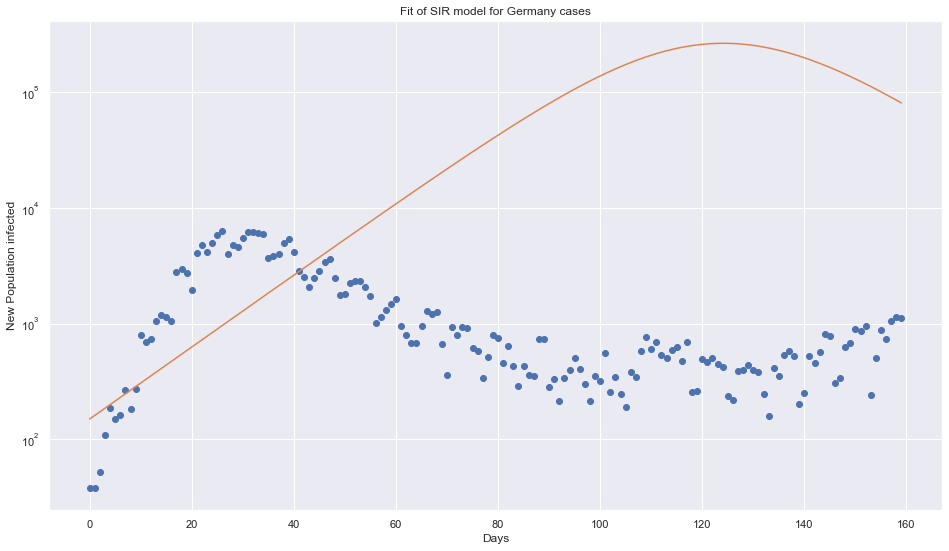

Optimal parameters: beta = 0.9136792025563819  and gamma =  0.8420755637382267
Basic Reproduction Number R0  1.0850323200215966


In [13]:
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])

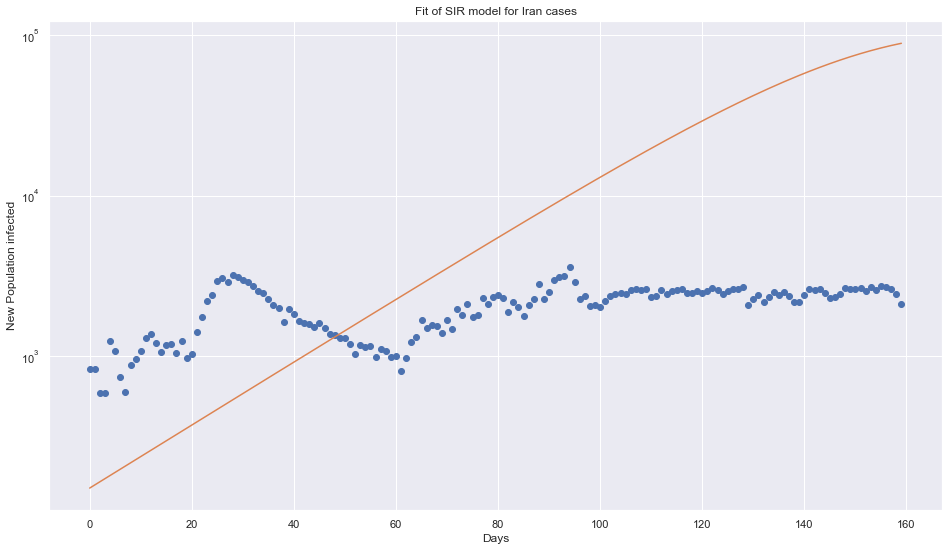

Optimal parameters: beta = 0.9288614271845095  and gamma =  0.8835570079108895
Basic Reproduction Number R0  1.0512750381333504


In [14]:
plt.semilogy(t,np.ediff1d(ydata2, to_begin=ydata2[1]-ydata2[0]), 'o')
plt.semilogy(t, fitted2)

plt.title("Fit of SIR model for Iran cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt2[0], " and gamma = ", popt2[1])
print("Basic Reproduction Number R0 " , popt2[0]/ popt2[1])

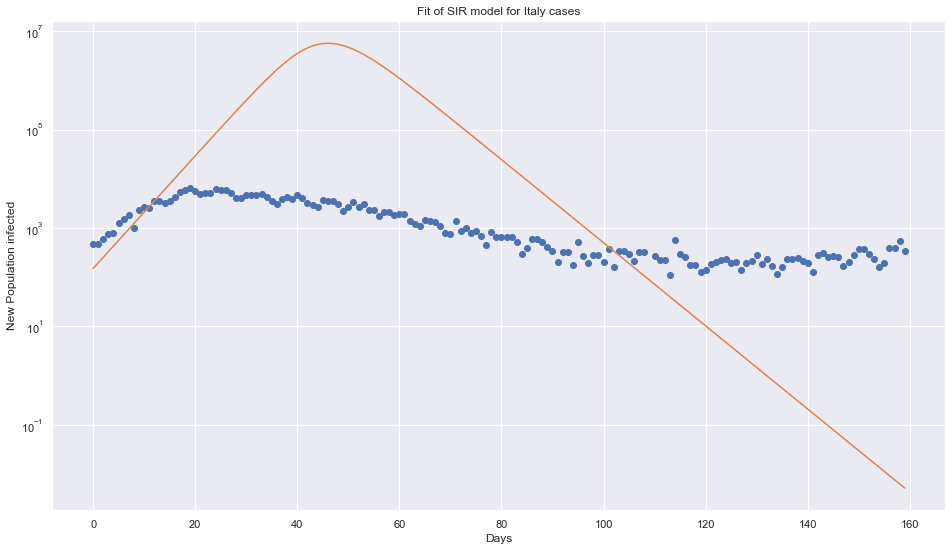

Optimal parameters: beta = 0.7633519156017868  and gamma =  0.49973447896186096
Basic Reproduction Number R0  1.527515005943876


In [15]:
plt.semilogy(t,np.ediff1d(ydata3, to_begin=ydata3[1]-ydata3[0]), 'o')
plt.semilogy(t, fitted3)

plt.title("Fit of SIR model for Italy cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt3[0], " and gamma = ", popt3[1])
print("Basic Reproduction Number R0 " , popt3[0]/ popt3[1])

Monitoring Data on Dashboard

In [16]:
import plotly
import plotly.graph_objects as go
import dash
from dash import dcc
from dash import html
fig=go.Figure()
#import dash_core_components as dcc
#import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    html.Label('Multi-Select Country'),
    dcc.Dropdown(
        id='country_drop_down',
        options=[{'label': each, 'value': each} for each in country_list],
                    
        value=['Germany'],
        multi=True
    ),


    dcc.Graph(figure=fig, id='main_window_slope')
])

In [17]:
from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):

    traces = []
    for each in country_list:
        if 'Iran' in country_list:
            traces.append(dict(x=t,
                           y=np.ediff1d(ydata2, to_begin=ydata2[1]-ydata2[0]),
                          mode='markers+lines',
                           opacity=0.9,
                           line_width=2,
                          marker_size=4,
                          name=each))
        
            traces.append(dict(x=t,
                           y=fitted2,
                          mode='markers+lines',
                           opacity=0.9,
                           line_width=2,
                          marker_size=4,
                          name=each))
        
        if 'Italy' in country_list:
            traces.append(dict(x=t,
                           y=np.ediff1d(ydata3, to_begin=ydata3[1]-ydata3[0]),
                          mode='markers+lines',
                           opacity=0.9,
                           line_width=2,
                          marker_size=4,
                          name=each))
        
            traces.append(dict(x=t,
                           y=fitted3,
                          mode='markers+lines',
                           opacity=0.9,
                           line_width=2,
                          marker_size=4,
                          name=each))
        if 'Germany' in country_list:
            traces.append(dict(x=t,
                           y=np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]),
                          mode='markers+lines',
                           opacity=0.9,
                           line_width=2,
                          marker_size=4,
                          name=each))
        
            traces.append(dict(x=t,
                           y=fitted,
                          mode='markers+lines',
                           opacity=0.9,
                           line_width=2,
                          marker_size=4,
                          name=each))

    return {
            'data': traces,
            'layout':dict (
                     width=1200,
                     height=700,
                
                     xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis={'type':"log",
               'title':'SIR'
              }   
        )
                               
           
     }



Navid Azadegan 

In [ ]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
